In [9]:
from minisom import MiniSom 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random 

from sklearn.preprocessing import StandardScaler

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [2]:
def balancedCut(df ,n ,frac = [0.5], target = 'Class',classes=[0,1]):
    random.seed(1)
    print(f'{"="*50}\nbalancedCut\n{"="*50}')
    print(f'Realizando seleccion de la muestra la muestra')
    newDfs = []
    if sum(frac) > 1:
        print(f'Valor de la fraccion incorrecto: --> {sum(frac)} > 1')
        
    if len(frac) < len(classes):
        frac.append(1-sum(frac))
    
    for cl,fc in zip(classes, frac):
        ndf = df[df[target]==cl]
        ro = ndf.shape[0]
        print(f'Dataset de clase --> {cl}')
        if int(fc*n) > ro:
            newDfs.append(ndf)
            print(f'\tFilas: {ro}')
        else:
            newDfs.append(ndf.sample(n=int(fc*n)))
            print(f'\tFilas: {int(fc*n)}')
    
    return pd.concat(newDfs), newDfs[1].shape[0]/newDfs[0].shape[0]

In [20]:
cards = pd.read_csv("/home/vcalzada/Work/proyecto/modelos/creditcard.csv")
cards = cards.sample(frac=1)


cards.head()

df, frac = balancedCut(cards, 40000, frac=[0.9])

balancedCut
Realizando seleccion de la muestra la muestra
Dataset de clase --> 0
	Filas: 36000
Dataset de clase --> 1
	Filas: 492


In [21]:
x = df.iloc[:,0:-1].to_numpy()

y = df.iloc[:,-1].to_numpy() 
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [22]:
m = Sequential()
m.add(Dense(512,  activation='elu', input_shape=(30,)))
m.add(Dense(128,  activation='elu'))
m.add(Dense(2,    activation='linear', name="bottleneck"))
m.add(Dense(128,  activation='elu'))
m.add(Dense(512,  activation='elu'))
m.add(Dense(30,  activation='sigmoid'))

In [23]:
m.compile(loss='mean_squared_error', optimizer = Adam())
history = m.fit(x, x, batch_size=20, epochs=10, verbose=1, 
                validation_data=(x, x))

encoder = Model(m.input, m.get_layer('bottleneck').output)
Zenc = encoder.predict(x)  # bottleneck representation
Renc = m.predict(x)        # reconstruction

Epoch 1/10
1825/1825 [==============================] - 27s 14ms/step - loss: 0.9476 - val_loss: 0.9280
Epoch 2/10
1825/1825 [==============================] - 36s 20ms/step - loss: 0.9239 - val_loss: 0.9200
Epoch 3/10
1825/1825 [==============================] - 24s 13ms/step - loss: 0.9165 - val_loss: 0.9154
Epoch 4/10
1825/1825 [==============================] - 30s 17ms/step - loss: 0.9140 - val_loss: 0.9121
Epoch 5/10
1825/1825 [==============================] - 32s 17ms/step - loss: 0.9130 - val_loss: 0.9127
Epoch 6/10
1825/1825 [==============================] - 39s 22ms/step - loss: 0.9119 - val_loss: 0.9136
Epoch 7/10
1825/1825 [==============================] - 25s 14ms/step - loss: 0.9110 - val_loss: 0.9074
Epoch 8/10
1825/1825 [==============================] - 24s 13ms/step - loss: 0.9084 - val_loss: 0.9042
Epoch 9/10
1825/1825 [==============================] - 26s 14ms/step - loss: 0.9047 - val_loss: 0.9030
Epoch 10/10
1825/1825 [==============================] - 31s 17m

In [24]:
n_neurons = 25
m_neurons = 25
x = Zenc
som = MiniSom(2, 1, x.shape[1], sigma=0.99, learning_rate=.2, 
              neighborhood_function='gaussian', random_seed=0)

som.train(x, 10000, verbose=True)




 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 17.51079699693184


Text(0, 0.5, 'frequency')

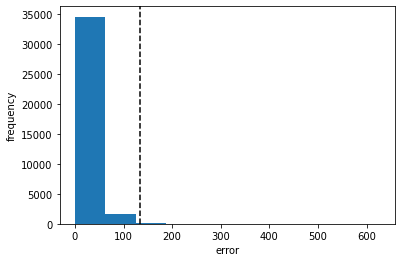

In [42]:
outliers_percentage=0.057
quantization_errors = np.linalg.norm(som.quantization(x) - x, axis=1)
error_treshold = np.percentile(quantization_errors, 
                               100*(1-outliers_percentage)+5)
is_outlier = quantization_errors > error_treshold
plt.hist(quantization_errors)
plt.axvline(error_treshold, color='k', linestyle='--')
plt.xlabel('error')
plt.ylabel('frequency')

In [43]:
y_pred = [int(i) for i in is_outlier]

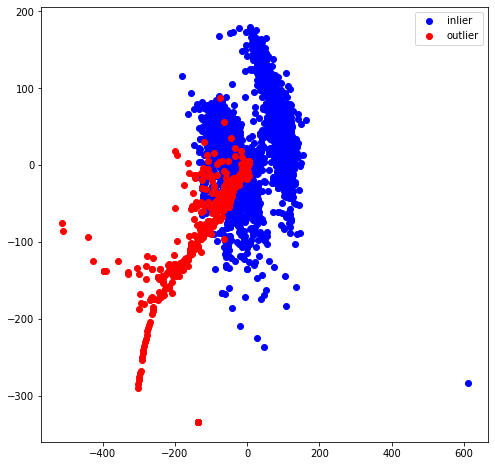

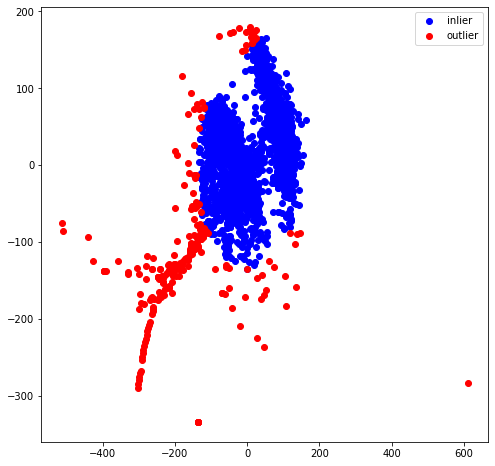

In [44]:
plt.figure(figsize=(8, 8))
plt.scatter(x[y==0, 0], x[y==0, 1],
            label='inlier',color="blue")
plt.scatter(x[y==1, 0], x[y==1, 1],
            label='outlier',color="red")
plt.legend()
plt.show()


plt.figure(figsize=(8, 8))
plt.scatter(x[~is_outlier, 0], x[~is_outlier, 1],
            label='inlier',color="blue")
plt.scatter(x[is_outlier, 0], x[is_outlier, 1],
            label='outlier',color="red")
plt.legend()
plt.show()

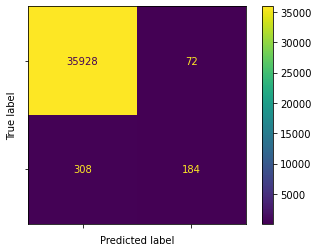

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(y, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[])
disp.plot()

In [46]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     36000
           1       0.72      0.37      0.49       492

    accuracy                           0.99     36492
   macro avg       0.86      0.69      0.74     36492
weighted avg       0.99      0.99      0.99     36492

